In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

**2a**

Originalne vrednosti (prve 3):
[ 1.7523539   0.7845019  -0.84813714]
Feature matrica (prva 3 reda):
[[ 1.7523539 ]
 [ 0.7845019 ]
 [-0.84813714]]
Epoch 1500/1500, Loss: 0.20732
Originalne vrednosti (prve 3):
[ 1.7523539   0.7845019  -0.84813714]
Feature matrica (prva 3 reda):
[[ 1.7523539   3.0707443 ]
 [ 0.7845019   0.6154432 ]
 [-0.84813714  0.7193366 ]]
Epoch 1500/1500, Loss: 0.20111
Originalne vrednosti (prve 3):
[ 1.7523539   0.7845019  -0.84813714]
Feature matrica (prva 3 reda):
[[ 1.7523539   3.0707443   5.3810306 ]
 [ 0.7845019   0.6154432   0.4828164 ]
 [-0.84813714  0.7193366  -0.6100961 ]]
Epoch 1500/1500, Loss: 0.22078
Originalne vrednosti (prve 3):
[ 1.7523539   0.7845019  -0.84813714]
Feature matrica (prva 3 reda):
[[ 1.7523539   3.0707443   5.3810306   9.42947   ]
 [ 0.7845019   0.6154432   0.4828164   0.3787704 ]
 [-0.84813714  0.7193366  -0.6100961   0.51744515]]
Epoch 1500/1500, Loss: 0.19998
Originalne vrednosti (prve 3):
[ 1.7523539   0.7845019  -0.84813714]
Feature

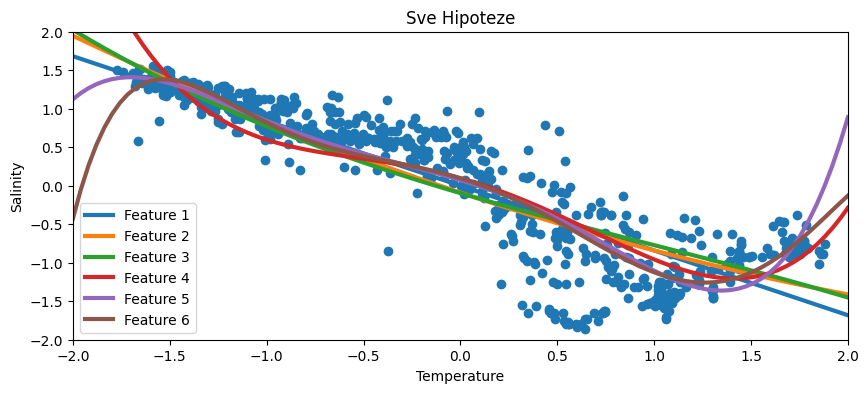

[<tf.Tensor: shape=(), dtype=float32, numpy=0.20730008>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20109196>, <tf.Tensor: shape=(), dtype=float32, numpy=0.220682>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1998924>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16403702>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15259288>]


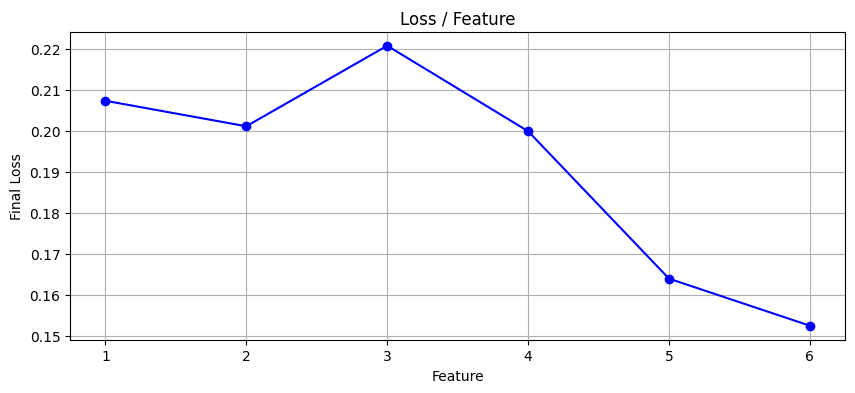

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Izbegavamo scientific notaciju i zaokruzujemo na 5 decimala.
# np.set_printoptions(suppress=True, precision=5)

# Učitavanje i obrada podataka.
filename = '/content/drive/MyDrive/Colab/bottle-700.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(5, 6), dtype='float32')
rows_with_nan = np.any(np.isnan(all_data), axis=1)
all_data = all_data[~rows_with_nan]
data = dict()
data['x'] = all_data[:, 0]
data['y'] = all_data[:, 1]

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Kreiranje feature matrice.
# Ovom promenljivom kontrolisemo broj feature-a tj. stepen polinoma. Varirati!
# nb_features = 1, avg loss u 1000toj epohi = 0.42
# nb_features = 9, avg loss u 1000toj epohi = 0.33
# Overfitting, regularizacija...

hyps = []
final_losses = []
model_parameters = {}

for nb_features in range(1, 7):
  print('Originalne vrednosti (prve 3):')
  print(data['x'][:3])
  print('Feature matrica (prva 3 reda):')
  curr_fm = create_feature_matrix(data['x'], nb_features)
  print(curr_fm[:3, :])

  # Model i parametri.
  w = tf.Variable(tf.zeros(nb_features))
  b = tf.Variable(0.0)

  learning_rate = 0.001
  nb_epochs = 1500

  def pred(x, w, b):
      w_col = tf.reshape(w, (nb_features, 1))
      hyp = tf.add(tf.matmul(x, w_col), b)
      return hyp

  # Funkcija troška i optimizacija.
  def loss(x, y, w, b, reg=None):
      prediction = pred(x, w, b)

      y_col = tf.reshape(y, (-1, 1))
      mse = tf.reduce_mean(tf.square(prediction - y_col))

      return mse

  # Računanje gradijenta
  def calc_grad(x, y, w, b):
      with tf.GradientTape() as tape:
          loss_val = loss(x, y, w, b)

      w_grad, b_grad = tape.gradient(loss_val, [w, b])

      return w_grad, b_grad, loss_val

  # Prelazimo na AdamOptimizer jer se prost GradientDescent lose snalazi sa
  # slozenijim funkcijama.
  adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Trening korak
  def train_step(x, y, w, b):
      w_grad, b_grad, loss = calc_grad(x, y, w, b)

      adam.apply_gradients(zip([w_grad, b_grad], [w, b]))

      return loss

  x_batch = curr_fm.reshape(nb_samples, nb_features)
  y_batch = data['y']

  for epoch in range(nb_epochs):
      curr_loss = train_step(x_batch, y_batch, w, b)

  print(f'Epoch {epoch+1}/{nb_epochs}, Loss: {curr_loss.numpy():.5f}')

  final_losses.append(loss(x_batch, y_batch, w, b))
  xs = create_feature_matrix(np.linspace(-2, 2, 100, dtype='float32'), nb_features)
  hyps.append(pred(xs, w, b))
  model_parameters[nb_features] = {'w': w, 'b': b}

# Ispisujemo i plotujemo finalnu vrednost parametara.

# Iscrtavanje.
plt.figure(figsize=(10, 4))
plt.scatter(data['x'], data['y'])
plt.title('Sve Hipoteze')
plt.xlabel('Temperature')
plt.ylabel('Salinity')

for idx, hyp_val in enumerate(hyps):
    plt.plot(xs[:, 0].tolist(), hyp_val.numpy(), label=f'Feature {idx+1}', linewidth=3)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.legend()
plt.show()

print(final_losses)

plt.figure(figsize=(10, 4))
plt.plot(range(1, nb_features+1), final_losses, marker='o', linestyle='-', color='blue')
plt.title('Loss / Feature')
plt.xlabel('Feature')
plt.ylabel('Final Loss')
plt.grid(True)
plt.show()

Na početku, gubitak blago varira, dostižući vrhunac kod treće karakteristike, a zatim značajno opada kako broj karakteristika raste.

Originalne vrednosti (prve 3):
[-1.0538257  -1.0348911  -0.36507943]
Feature matrica (prva 3 reda):
[[-1.0538257 ]
 [-1.0348911 ]
 [-0.36507943]]
Originalne vrednosti (prve 3):
[-1.0538257  -1.0348911  -0.36507943]
Feature matrica (prva 3 reda):
[[-1.0538257   1.1105487 ]
 [-1.0348911   1.0709996 ]
 [-0.36507943  0.13328299]]
Originalne vrednosti (prve 3):
[-1.0538257  -1.0348911  -0.36507943]
Feature matrica (prva 3 reda):
[[-1.0538257   1.1105487  -1.1703248 ]
 [-1.0348911   1.0709996  -1.108368  ]
 [-0.36507943  0.13328299 -0.04865888]]
Originalne vrednosti (prve 3):
[-1.0538257  -1.0348911  -0.36507943]
Feature matrica (prva 3 reda):
[[-1.0538257   1.1105487  -1.1703248   1.2333183 ]
 [-1.0348911   1.0709996  -1.108368    1.1470402 ]
 [-0.36507943  0.13328299 -0.04865888  0.01776436]]
Originalne vrednosti (prve 3):
[-1.0538257  -1.0348911  -0.36507943]
Feature matrica (prva 3 reda):
[[-1.0538257   1.1105487  -1.1703248   1.2333183  -1.2997026 ]
 [-1.0348911   1.0709996  -1.108368  

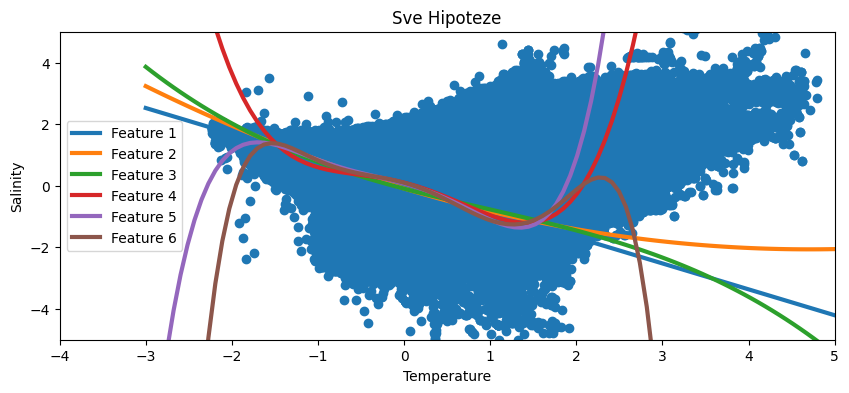

[<tf.Tensor: shape=(), dtype=float32, numpy=0.85719806>, <tf.Tensor: shape=(), dtype=float32, numpy=0.73856586>, <tf.Tensor: shape=(), dtype=float32, numpy=0.79608315>, <tf.Tensor: shape=(), dtype=float32, numpy=3.6095436>, <tf.Tensor: shape=(), dtype=float32, numpy=35.366444>, <tf.Tensor: shape=(), dtype=float32, numpy=38.579075>]


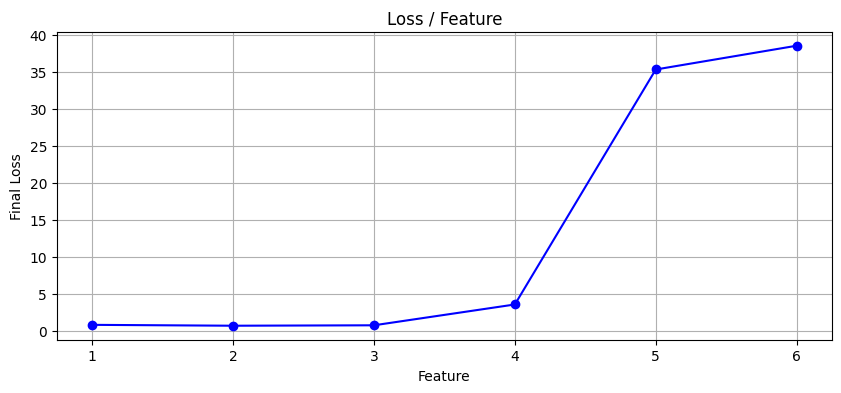

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Izbegavamo scientific notaciju i zaokruzujemo na 5 decimala.
# np.set_printoptions(suppress=True, precision=5)

# Učitavanje i obrada podataka.
filename = '/content/drive/MyDrive/Colab/bottle.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=702, usecols=(5, 6), dtype='float32')
rows_with_nan = np.any(np.isnan(all_data), axis=1)
all_data = all_data[~rows_with_nan]
data = dict()
data['x'] = all_data[:, 0]
data['y'] = all_data[:, 1]

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Kreiranje feature matrice.
# Ovom promenljivom kontrolisemo broj feature-a tj. stepen polinoma. Varirati!
# nb_features = 1, avg loss u 1000toj epohi = 0.42
# nb_features = 9, avg loss u 1000toj epohi = 0.33
# Overfitting, regularizacija...

hyps = []
final_losses = []

for nb_features in range(1, 7):
  print('Originalne vrednosti (prve 3):')
  print(data['x'][:3])
  print('Feature matrica (prva 3 reda):')
  curr_fm = create_feature_matrix(data['x'], nb_features)
  print(curr_fm[:3, :])

  w = model_parameters[nb_features]['w']
  b = model_parameters[nb_features]['b']

  def pred(x, w, b):
      w_col = tf.reshape(w, (nb_features, 1))
      hyp = tf.add(tf.matmul(x, w_col), b)
      return hyp

  # Funkcija troška i optimizacija.
  def loss(x, y, w, b, reg=None):
      prediction = pred(x, w, b)

      y_col = tf.reshape(y, (-1, 1))
      mse = tf.reduce_mean(tf.square(prediction - y_col))

      return mse

  x_batch = curr_fm.reshape(nb_samples, nb_features)
  y_batch = data['y']

  final_losses.append(loss(x_batch, y_batch, w, b))
  xs = create_feature_matrix(np.linspace(-3, 5, 100, dtype='float32'), nb_features)
  hyps.append(pred(xs, w, b))

# Ispisujemo i plotujemo finalnu vrednost parametara.

# Iscrtavanje.
plt.figure(figsize=(10, 4))
plt.scatter(data['x'], data['y'])
plt.title('Sve Hipoteze')
plt.xlabel('Temperature')
plt.ylabel('Salinity')

for idx, hyp_val in enumerate(hyps):
    plt.plot(xs[:, 0].tolist(), hyp_val.numpy(), label=f'Feature {idx+1}', linewidth=3)
plt.xlim([-4, 5])
plt.ylim([-5, 5])
plt.legend()
plt.show()

print(final_losses)

plt.figure(figsize=(10, 4))
plt.plot(range(1, nb_features+1), final_losses, marker='o', linestyle='-', color='blue')
plt.title('Loss / Feature')
plt.xlabel('Feature')
plt.ylabel('Final Loss')
plt.grid(True)
plt.show()

**2b**

Originalne vrednosti (prve 3):
[-0.8285846  -0.21267876 -0.9133123 ]
Feature matrica (prva 3 reda):
[[-0.8285846   0.68655246 -0.5688668   0.47135428]
 [-0.21267876  0.04523226 -0.00961994  0.00204596]
 [-0.9133123   0.8341394  -0.7618298   0.6957885 ]]
Epoch 1500/1500, Loss: 0.19998
Originalne vrednosti (prve 3):
[-0.8285846  -0.21267876 -0.9133123 ]
Feature matrica (prva 3 reda):
[[-0.8285846   0.68655246 -0.5688668   0.47135428]
 [-0.21267876  0.04523226 -0.00961994  0.00204596]
 [-0.9133123   0.8341394  -0.7618298   0.6957885 ]]
Epoch 1500/1500, Loss: 0.20021
Originalne vrednosti (prve 3):
[-0.8285846  -0.21267876 -0.9133123 ]
Feature matrica (prva 3 reda):
[[-0.8285846   0.68655246 -0.5688668   0.47135428]
 [-0.21267876  0.04523226 -0.00961994  0.00204596]
 [-0.9133123   0.8341394  -0.7618298   0.6957885 ]]
Epoch 1500/1500, Loss: 0.20231
Originalne vrednosti (prve 3):
[-0.8285846  -0.21267876 -0.9133123 ]
Feature matrica (prva 3 reda):
[[-0.8285846   0.68655246 -0.5688668   0.4713

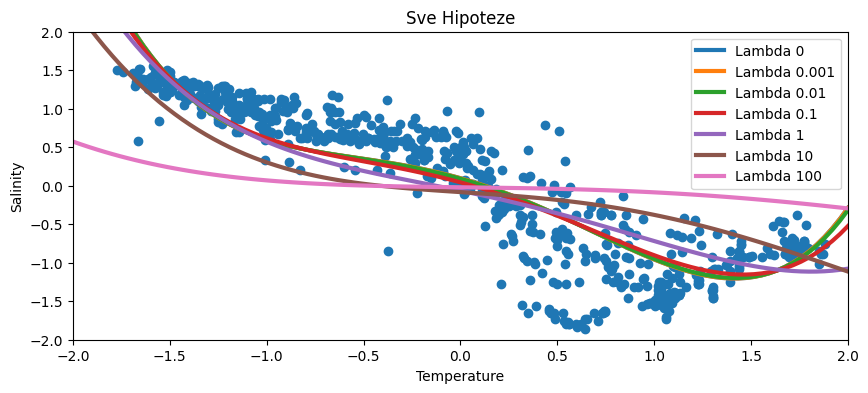

[<tf.Tensor: shape=(), dtype=float32, numpy=0.19989237>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20012748>, <tf.Tensor: shape=(), dtype=float32, numpy=0.20222087>, <tf.Tensor: shape=(), dtype=float32, numpy=0.22125502>, <tf.Tensor: shape=(), dtype=float32, numpy=0.33529168>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5962085>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9046181>]


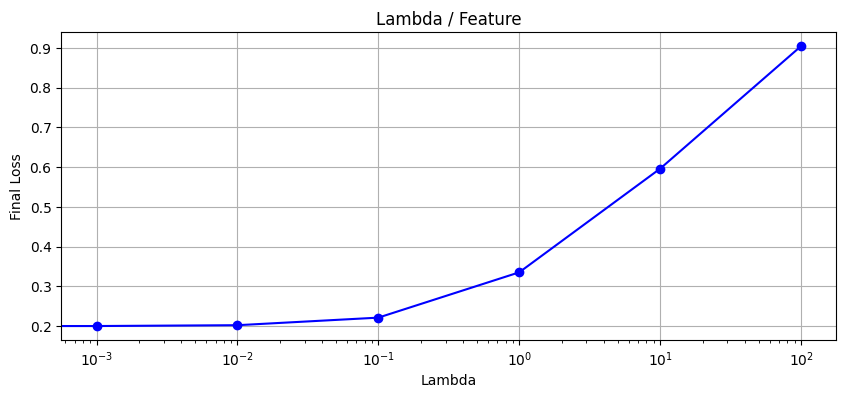

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Izbegavamo scientific notaciju i zaokruzujemo na 5 decimala.
# np.set_printoptions(suppress=True, precision=5)

# Učitavanje i obrada podataka.
filename = '/content/drive/MyDrive/Colab/bottle-700.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(5, 6), dtype='float32')
rows_with_nan = np.any(np.isnan(all_data), axis=1)
all_data = all_data[~rows_with_nan]
data = dict()
data['x'] = all_data[:, 0]
data['y'] = all_data[:, 1]

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Kreiranje feature matrice.
# Ovom promenljivom kontrolisemo broj feature-a tj. stepen polinoma. Varirati!
# nb_features = 1, avg loss u 1000toj epohi = 0.42
# nb_features = 9, avg loss u 1000toj epohi = 0.33
# Overfitting, regularizacija...

hyps = []
final_losses = []
nb_features = 4
curr_fm = create_feature_matrix(data['x'], nb_features)
lmbds = [0, 0.001, 0.01, 0.1, 1, 10, 100]
model_parameters = {}

for lmbd in lmbds:
  print('Originalne vrednosti (prve 3):')
  print(data['x'][:3])
  print('Feature matrica (prva 3 reda):')
  print(curr_fm[:3, :])

  # Model i parametri.
  w = tf.Variable(tf.zeros(nb_features))
  b = tf.Variable(0.0)

  learning_rate = 0.001
  nb_epochs = 1500

  def pred(x, w, b):
      w_col = tf.reshape(w, (nb_features, 1))
      hyp = tf.add(tf.matmul(x, w_col), b)
      return hyp

  # Funkcija troška i optimizacija.
  def loss(x, y, w, b, reg=None):
      prediction = pred(x, w, b)

      y_col = tf.reshape(y, (-1, 1))
      mse = tf.reduce_mean(tf.square(prediction - y_col))

      # Regularizacija
      l2_reg = lmbd * tf.reduce_mean(tf.square(w))
      loss = tf.add(mse, l2_reg)

      return loss

  # Računanje gradijenta
  def calc_grad(x, y, w, b):
      with tf.GradientTape() as tape:
          loss_val = loss(x, y, w, b)

      w_grad, b_grad = tape.gradient(loss_val, [w, b])

      return w_grad, b_grad, loss_val

  # Prelazimo na AdamOptimizer jer se prost GradientDescent lose snalazi sa
  # slozenijim funkcijama.
  adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Trening korak
  def train_step(x, y, w, b):
      w_grad, b_grad, loss = calc_grad(x, y, w, b)

      adam.apply_gradients(zip([w_grad, b_grad], [w, b]))

      return loss

  x_batch = curr_fm.reshape(nb_samples, nb_features)
  y_batch = data['y']

  for epoch in range(nb_epochs):
      curr_loss = train_step(x_batch, y_batch, w, b)
      if epoch == 1499:
          print(f'Epoch {epoch+1}/{nb_epochs}, Loss: {curr_loss.numpy():.5f}')

  final_losses.append(loss(x_batch, y_batch, w, b))
  xs = create_feature_matrix(np.linspace(-2, 2, 100, dtype='float32'), nb_features)
  hyps.append(pred(xs, w, b))
  model_parameters[lmbd] = {'w': w, 'b': b}

# Ispisujemo i plotujemo finalnu vrednost parametara.

# Iscrtavanje.
plt.figure(figsize=(10, 4))
plt.scatter(data['x'], data['y'])
plt.title('Sve Hipoteze')
plt.xlabel('Temperature')
plt.ylabel('Salinity')

for idx, hyp_val in enumerate(hyps):
    plt.plot(xs[:, 0].tolist(), hyp_val.numpy(), label=f'Lambda {lmbds[idx]}', linewidth=3)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.legend()
plt.show()

print(final_losses)

plt.figure(figsize=(10, 4))
plt.plot(lmbds, final_losses, marker='o', linestyle='-', color='blue')
plt.title('Lambda / Feature')
plt.xlabel('Lambda')
plt.ylabel('Final Loss')
plt.xscale('log')
plt.grid(True)
plt.show()

Na grafu vidimo da gubitak raste sa povećanjem vrednosti lambda. Za male vrednosti lambda, uticaj na gubitak je mali. Uticaj je drastično raste kako se povećava razlika između lambde i nekog prosecnog gubitka.

Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vrednosti (prve 3):
[ 0.91 -0.4   0.97]
Feature matrica (prva 3 reda):
[[ 0.91  0.82  0.74  0.67]
 [-0.4   0.16 -0.06  0.03]
 [ 0.97  0.93  0.9   0.87]]
Originalne vredn

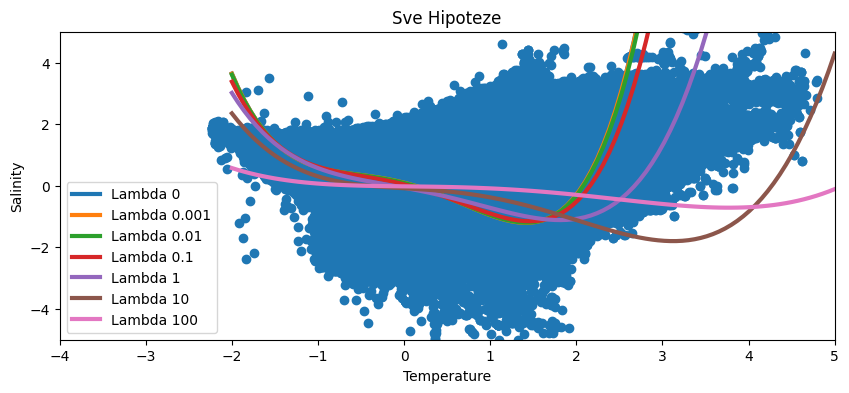

[<tf.Tensor: shape=(), dtype=float32, numpy=3.609549>, <tf.Tensor: shape=(), dtype=float32, numpy=3.5888069>, <tf.Tensor: shape=(), dtype=float32, numpy=3.411339>, <tf.Tensor: shape=(), dtype=float32, numpy=2.2671926>, <tf.Tensor: shape=(), dtype=float32, numpy=0.84190655>, <tf.Tensor: shape=(), dtype=float32, numpy=0.95761585>, <tf.Tensor: shape=(), dtype=float32, numpy=0.99220914>]


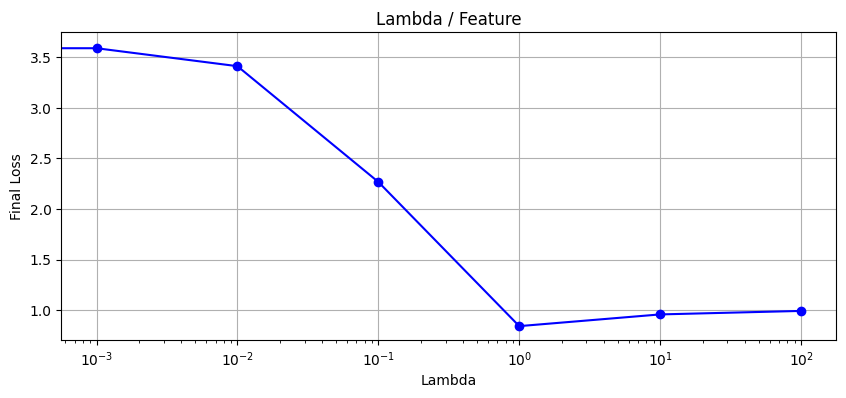

In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
  tmp_features = []
  for deg in range(1, nb_features+1):
    tmp_features.append(np.power(x, deg))
  return np.column_stack(tmp_features)

# Izbegavamo scientific notaciju i zaokruzujemo na 5 decimala.
# np.set_printoptions(suppress=True, precision=5)

# Učitavanje i obrada podataka.
filename = '/content/drive/MyDrive/Colab/bottle.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=702, usecols=(5, 6), dtype='float32')
rows_with_nan = np.any(np.isnan(all_data), axis=1)
all_data = all_data[~rows_with_nan]
data = dict()
data['x'] = all_data[:, 0]
data['y'] = all_data[:, 1]

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Kreiranje feature matrice.
# Ovom promenljivom kontrolisemo broj feature-a tj. stepen polinoma. Varirati!
# nb_features = 1, avg loss u 1000toj epohi = 0.42
# nb_features = 9, avg loss u 1000toj epohi = 0.33
# Overfitting, regularizacija...

hyps = []
final_losses = []
nb_features = 4
curr_fm = create_feature_matrix(data['x'], nb_features)
lmbds = [0, 0.001, 0.01, 0.1, 1, 10, 100]

for lmbd in lmbds:
  print('Originalne vrednosti (prve 3):')
  print(data['x'][:3])
  print('Feature matrica (prva 3 reda):')
  print(curr_fm[:3, :])

  w = model_parameters[lmbd]['w']
  b = model_parameters[lmbd]['b']

  def pred(x, w, b):
      w_col = tf.reshape(w, (nb_features, 1))
      hyp = tf.add(tf.matmul(x, w_col), b)
      return hyp

  # Funkcija troška i optimizacija.
  def loss(x, y, w, b, reg=None):
      prediction = pred(x, w, b)

      y_col = tf.reshape(y, (-1, 1))
      mse = tf.reduce_mean(tf.square(prediction - y_col))

      # Regularizacija
      l2_reg = lmbd * tf.reduce_mean(tf.square(w))
      loss = tf.add(mse, l2_reg)

      return loss

  x_batch = curr_fm.reshape(nb_samples, nb_features)
  y_batch = data['y']

  final_losses.append(loss(x_batch, y_batch, w, b))
  xs = create_feature_matrix(np.linspace(-2, 5, 100, dtype='float32'), nb_features)
  hyps.append(pred(xs, w, b))

# Ispisujemo i plotujemo finalnu vrednost parametara.

# Iscrtavanje.
plt.figure(figsize=(10, 4))
plt.scatter(data['x'], data['y'])
plt.title('Sve Hipoteze')
plt.xlabel('Temperature')
plt.ylabel('Salinity')

for idx, hyp_val in enumerate(hyps):
    plt.plot(xs[:, 0].tolist(), hyp_val.numpy(), label=f'Lambda {lmbds[idx]}', linewidth=3)
plt.xlim([-4, 5])
plt.ylim([-5, 5])
plt.legend()
plt.show()

print(final_losses)

plt.figure(figsize=(10, 4))
plt.plot(lmbds, final_losses, marker='o', linestyle='-', color='blue')
plt.title('Lambda / Feature')
plt.xlabel('Lambda')
plt.ylabel('Final Loss')
plt.xscale('log')
plt.grid(True)
plt.show()

**3a**

24 matches out of 30 examples
Test set accuracy: 0.8000


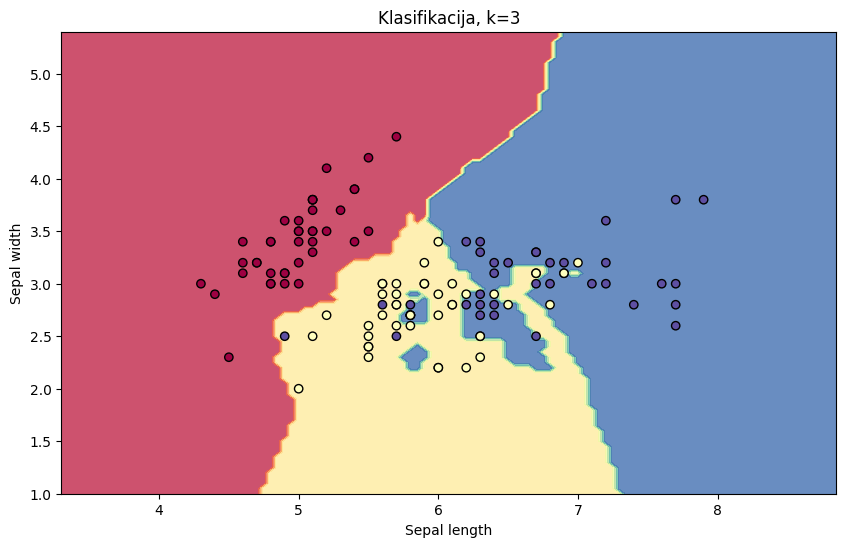

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

class KNN:

    def __init__(self, nb_classes, nb_features, X, Y, k, weighted=False):
        self.nb_classes = nb_classes
        self.nb_features = nb_features
        self.k = k
        self.weighted = weighted
        self.X_train = tf.convert_to_tensor(X, dtype=tf.float32)
        self.Y_train = tf.convert_to_tensor(Y, dtype=tf.int32)


    def predict(self, X_test, Y_test=None):
        nb_queries = X_test.shape[0]

        Y_pred = []
        for i in range(nb_queries):
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X_train, X_test[i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)

            classes = tf.gather(self.Y_train, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / dists
                w = tf.gather(w, idxs)
            else:
                w = tf.fill([self.k], 1.0 / self.k)

            w_col = tf.reshape(w, (self.k, 1))
            one_hot_labels = tf.one_hot(classes, depth=self.nb_classes)
            scores = tf.reduce_sum(w_col * one_hot_labels, axis=0)

            Y_pred.append(tf.argmax(scores).numpy())

        if Y_test is not None:
            matches = 0
            for i, prediction in enumerate(Y_pred):
                if prediction == Y_test[i]:
                    matches += 1

            accuracy = matches / nb_queries
            print(f'{matches} matches out of {nb_queries} examples')
            print(f'Test set accuracy: {accuracy:.4f}')

        return np.array(Y_pred)

    def visualize_decision_boundaries(self):
        h = .05
        x_min, x_max = self.X_train[:, 0].numpy().min() - 1, self.X_train[:, 0].numpy().max() + 1
        y_min, y_max = self.X_train[:, 1].numpy().min() - 1, self.X_train[:, 1].numpy().max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # np.c_[] kombinuje dva niza u jedan tako što redove prvog niza postavlja kao x koordinate, a redove drugog niza kao y koordinate.
        # ravel() pretvara matrice koordinata u jednodimenzionalne nizove.
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])

        # menja oblik niza Z da odgovara obliku mreže xx i yy, ovo je potrebno kako bi se mogao pravilno prikazati kontur grafik.
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(10, 6))

        # crta konture za predikcije, xx i yy su koordinate, Z je matrica predikcija
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c=self.Y_train, cmap=plt.cm.Spectral,
            edgecolor='k')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("Klasifikacija, k=3")
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')


iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

nb_classes=3
k=3
nb_features=2

knn = KNN(nb_classes, nb_features, X_train, y_train, k, False)

knn.predict(X_test, y_test)

knn.visualize_decision_boundaries()
plt.show()


**3b**

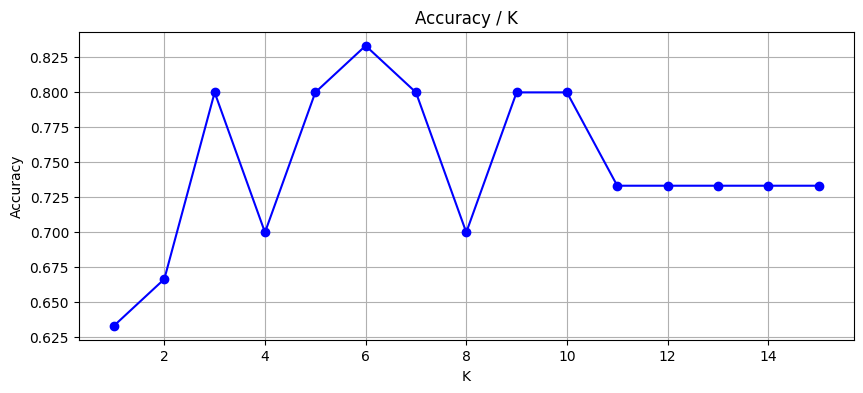

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

class KNN:
    def __init__(self, nb_classes, nb_features, X, Y, k, weighted=False):
        self.nb_classes = nb_classes
        self.nb_features = nb_features
        self.k = k
        self.weighted = weighted
        self.X_train = tf.convert_to_tensor(X, dtype=tf.float32)
        self.Y_train = tf.convert_to_tensor(Y, dtype=tf.int32)

    def predict(self, X_test, Y_test=None):
        nb_queries = X_test.shape[0]
        Y_pred = []
        for i in range(nb_queries):
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X_train, X_test[i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)
            classes = tf.gather(self.Y_train, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / dists
                w = tf.gather(w, idxs)
            else:
                w = tf.fill([self.k], 1.0 / self.k)

            w_col = tf.reshape(w, (self.k, 1))
            one_hot_labels = tf.one_hot(classes, depth=self.nb_classes)
            scores = tf.reduce_sum(w_col * one_hot_labels, axis=0)
            Y_pred.append(tf.argmax(scores).numpy())

        if Y_test is not None:
            matches = 0
            for i, prediction in enumerate(Y_pred):
                if prediction == Y_test[i]:
                    matches += 1
            accuracy = matches / nb_queries
            return accuracy, np.array(Y_pred)

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

k_values = range(1, 16)
accuracies = []

for k in k_values:
    knn = KNN(3, 2, X_train, y_train, k, False)
    accuracy, _ = knn.predict(X_test, y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 4))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy / K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


Najbolja preciznost je kada je k=6

**3c**

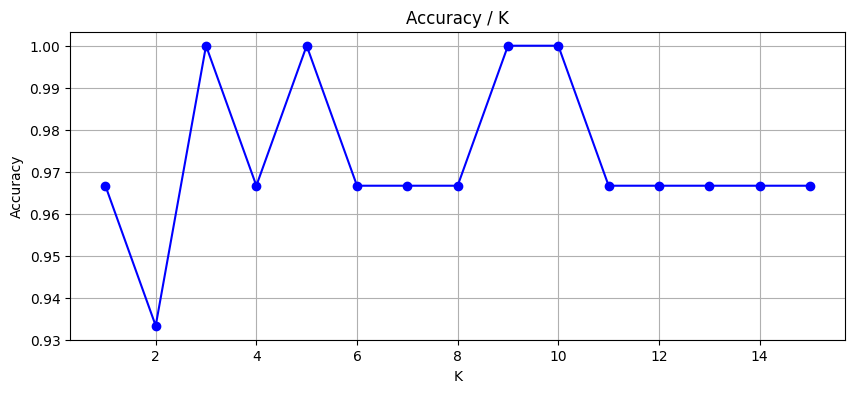

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

class KNN:
    def __init__(self, nb_classes, nb_features, X, Y, k, weighted=False):
        self.nb_classes = nb_classes
        self.nb_features = nb_features
        self.k = k
        self.weighted = weighted
        self.X_train = tf.convert_to_tensor(X, dtype=tf.float32)
        self.Y_train = tf.convert_to_tensor(Y, dtype=tf.int32)

    def predict(self, X_test, Y_test=None):
        nb_queries = X_test.shape[0]
        Y_pred = []
        for i in range(nb_queries):
            dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X_train, X_test[i])), axis=1))
            _, idxs = tf.nn.top_k(-dists, self.k)
            classes = tf.gather(self.Y_train, idxs)
            dists = tf.gather(dists, idxs)

            if self.weighted:
                w = 1 / dists
                w = tf.gather(w, idxs)
            else:
                w = tf.fill([self.k], 1.0 / self.k)

            w_col = tf.reshape(w, (self.k, 1))
            one_hot_labels = tf.one_hot(classes, depth=self.nb_classes)
            scores = tf.reduce_sum(w_col * one_hot_labels, axis=0)
            Y_pred.append(tf.argmax(scores).numpy())

        if Y_test is not None:
            matches = 0
            for i, prediction in enumerate(Y_pred):
                if prediction == Y_test[i]:
                    matches += 1
            accuracy = matches / nb_queries
            return accuracy, np.array(Y_pred)

iris = datasets.load_iris()
X = iris.data[:, :4]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

k_values = range(1, 16)
accuracies = []

for k in k_values:
    knn = KNN(3, 2, X_train, y_train, k, False)
    accuracy, _ = knn.predict(X_test, y_test)
    accuracies.append(accuracy)

plt.figure(figsize=(10, 4))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy / K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Kada se koristi više feature preciznost je generalno veća i za k= 3,5,9 i 10 dostiže 100%

**4**

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download()

In [ ]:
import nltk
from nltk import FreqDist
from nltk.tokenize import wordpunct_tokenize, regexp_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import math
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

porter = PorterStemmer()

filename = '/content/drive/MyDrive/Colab/disaster-tweets.csv'

df = pd.read_csv(filename)

# Split data
num_samples = df.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Cistimo korpus
print('Cleaning the corpus...')
clean_corpus = []

def remove_emojis(text):
    # Unicode ranges for most emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

stop_punc = set(stopwords.words('english')).union(set(punctuation))

for doc in df['text']:
  doc_no_emojis = remove_emojis(doc)
  words = regexp_tokenize(doc_no_emojis, "[\w']+")
  words_lower = [w.lower() for w in words]
  words_filtered = [w for w in words_lower if not (w in stop_punc or w.startswith('http') or w.startswith('https') or w.isdigit() or w.endswith('_') or w == 'co')]
  words_stemmed = [porter.stem(w) for w in words_filtered]
  clean_corpus.append(words_stemmed)
  # Primetiti razliku u vokabularu kada se koraci izostave

training = [clean_corpus[i] for i in train_indices]
testing = [clean_corpus[i] for i in test_indices]
Y_training = np.array(df['target'])[train_indices]
Y_test = np.array(df['target'])[test_indices]

np.set_printoptions(precision=2, linewidth=200)

# Najcesce reci u trening skupu
flat_list = [word for sublist in training for word in sublist]
word_counts = Counter(flat_list)
most_common = word_counts.most_common(10000)
print("Most common words:")
print(most_common[:90])

vocabulary = [word for word, count in most_common]
vocab_index = {word: i for i, word in enumerate(vocabulary)}  # Koja rec je na kojoj poziciji u feature vektoru 10000

def tweet_to_vector(document, vocab_index):
    bow_vector = np.zeros(len(vocab_index), dtype=int)

    for word in document:
        if word in vocab_index:
            bow_vector[vocab_index[word]] += 1
    return bow_vector

X_training = np.array([tweet_to_vector(doc, vocab_index) for doc in training])
X_test = np.array([tweet_to_vector(doc, vocab_index) for doc in testing])


class MultinomialNaiveBayes:
  def __init__(self, nb_classes, nb_words, pseudocount):
    self.nb_classes = nb_classes
    self.nb_words = nb_words
    self.pseudocount = pseudocount

  def fit(self, X, Y):
    nb_examples = X.shape[0]

    # Racunamo P(Klasa) - priors
    # np.bincount nam za datu listu vraca broj pojavljivanja svakog celog
    # broja u intervalu [0, maksimalni broj u listi]
    self.priors = np.bincount(Y) / nb_examples
    print('Priors:')
    print(self.priors)

    # Racunamo broj pojavljivanja svake reci u svakoj klasi
    occs = np.zeros((self.nb_classes, self.nb_words))
    for i in range(nb_examples):
      c = Y[i]
      for w in range(self.nb_words):
        cnt = X[i][w]
        occs[c][w] += cnt
    # print('Occurences:')
    # print(occs)

    # Racunamo P(Rec_i|Klasa) - likelihoods
    self.like = np.zeros((self.nb_classes, self.nb_words))
    for c in range(self.nb_classes):
      for w in range(self.nb_words):
        up = occs[c][w] + self.pseudocount
        down = np.sum(occs[c]) + self.nb_words*self.pseudocount
        self.like[c][w] = up / down
    # print('Likelihoods:')
    # print(self.like)

  def predict(self, X_test):
        nb_examples = len(X_test)
        preds = []
        for i in range(nb_examples):
            # Racunamo P(Klasa|bow) za svaku klasu
            log_probs = []
            for c in range(self.nb_classes):
                log_prob = np.log(self.priors[c])
                for w in range(len(X_test[i])):
                    log_prob += X_test[i][w] * np.log(self.like[c][w])
                log_probs.append(log_prob)

            pred = log_probs.index(max(log_probs))
            preds.append(pred)
        return preds

def calc_acc(labels, predictions):
        nb_correct = 0
        nb_total = len(labels)
        for i in range(nb_total):
            if labels[i] == predictions[i]:
                nb_correct += 1
        return nb_correct / nb_total

model = MultinomialNaiveBayes(nb_classes=2, nb_words=10000, pseudocount=1)
model.fit(X_training, Y_training)
prediction = model.predict(X_test)
print('Predicted class (with log): ', prediction)
print('Accuracy: ', calc_acc(Y_test, prediction))

Cleaning the corpus...
Most common words:
[('like', 323), ('fire', 280), ('amp', 279), ('get', 244), ("i'm", 194), ('bomb', 192), ('via', 176), ('new', 174), ('one', 161), ('go', 158), ('peopl', 154), ('news', 154), ('burn', 153), ('kill', 139), ('time', 137), ('year', 133), ('disast', 133), ('crash', 132), ('video', 130), ('flood', 130), ('emerg', 127), ('build', 126), ('attack', 126), ('polic', 125), ('look', 123), ('say', 122), ('bodi', 121), ('day', 119), ('home', 118), ('fatal', 117), ('make', 115), ('u', 107), ('love', 107), ('ûª', 106), ('us', 106), ('would', 106), ('see', 105), ('know', 105), ('back', 104), ('evacu', 103), ('famili', 102), ('storm', 101), ('train', 101), ('still', 101), ('come', 100), ('watch', 98), ('live', 97), ('bag', 96), ('suicid', 95), ('world', 95), ('got', 93), ('california', 93), ('want', 92), ('scream', 91), ('first', 90), ('collaps', 90), ('death', 88), ('man', 88), ('rt', 87), ('war', 86), ('car', 86), ('feel', 84), ('derail', 83), ('need', 83), ('t

In [ ]:
def analyze_top_words(corpus, labels, vocab_index):
    pos_word_counts = Counter()
    neg_word_counts = Counter()

    # Split the corpus into positive and negative based on labels
    for doc, label in zip(corpus, labels):
        if label == 1:  # Positive tweets
            pos_word_counts.update(doc)
        else:  # Negative tweets
            neg_word_counts.update(doc)

    # Find top 5 words in positive and negative tweets
    most_common_pos = pos_word_counts.most_common(5)
    most_common_neg = neg_word_counts.most_common(5)

    # Calculate LR metrics for words present at least 10 times in both corpuses
    lr_scores = {}
    for word in vocab_index.keys():
        if pos_word_counts[word] >= 10 and neg_word_counts[word] >= 10:
            lr_scores[word] = pos_word_counts[word] / neg_word_counts[word]

    top_lr = sorted(lr_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    bottom_lr = sorted(lr_scores.items(), key=lambda x: x[1])[:5]

    return most_common_pos, most_common_neg, top_lr, bottom_lr

# ceo korpus
most_common_pos, most_common_neg, top_lr, bottom_lr = analyze_top_words(clean_corpus, df['target'], vocab_index)

print("Top 5 words in positive tweets:")
print(most_common_pos)
print("Top 5 words in negative tweets:")
print(most_common_neg)
print("Top 5 words by highest LR metric:")
print(top_lr)
print("Top 5 words by lowest LR metric:")
print(bottom_lr)


Top 5 words in positive tweets:
[('fire', 269), ('bomb', 184), ('kill', 161), ('news', 140), ('amp', 135)]
Top 5 words in negative tweets:
[('like', 308), ('get', 221), ('amp', 209), ("i'm", 198), ('new', 170)]
Top 5 words by highest LR metric:
[('kill', 8.473684210526315), ('train', 5.7368421052631575), ('report', 5.153846153846154), ('latest', 4.0), ('oil', 4.0)]
Top 5 words by lowest LR metric:
[('full', 0.11904761904761904), ('love', 0.14516129032258066), ('obliter', 0.15384615384615385), ('scream', 0.16161616161616163), ('let', 0.18055555555555555)]


Kao što je očekivano, 5 najčešćih reči u pozitivnoj grupi su vezane za nezgode, a 5 najčešćih u negativnoj su neke česte reči u Englskom koje nisu vezane za nezgode. Međutim, postoje reči amp koje se pojavljuju često u oba slučaja.

Zbog toga je dobro koristi metrike kao što je LR, koja posmatra odnos između pojavljivanja reči u ova 2 skupa. Kada je LR metrika visoka to znači da se reč pojavljuje veoma često u pozitivnom skupu, ali u isto vreme jako retko u negativnom skupu, suprotan odnos važi kada je LR metrika mala, to na omogućava da izbegnemo generalno česte reči u engleskom jeziku i fokusiramo se na reči koje su relevantne za negativne, odnosno pozitivne tvitove.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
from nltk import FreqDist
from nltk.tokenize import wordpunct_tokenize, regexp_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np
import math
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from collections import Counter

porter = PorterStemmer()

filename = '/content/drive/MyDrive/Colab/disaster-tweets.csv'

df = pd.read_csv(filename)

# stop_words = set(stopwords.words('english'))

# def clean_text(text):
#     text = re.sub(r'http\S+', '', text)   # Remove URLs
#     tokens = regexp_tokenize(text, "(?:(?!\bhttp[s]?://)\w)+")
#     text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) # Remove punctuation and numbers
#     text = text.lower().strip()

# df['cleaned_text'] = df['text'].apply(clean_text)

# Cistimo korpus
print('Cleaning the corpus...')
clean_corpus = []

def remove_emojis(text):
    # Unicode ranges for most emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

stop_punc = set(stopwords.words('english')).union(set(punctuation))

for doc in df['text']:
  doc_no_emojis = remove_emojis(doc)
  words = regexp_tokenize(doc_no_emojis, "[\w']+")
  words_lower = [w.lower() for w in words]
  words_filtered = [w for w in words_lower if not (w in stop_punc or w.startswith('http') or w.startswith('https') or w.isdigit() or "_" in w)]
  words_stemmed = [porter.stem(w) for w in words_filtered]
  clean_corpus.append(words_stemmed)

flat_list = [word for sublist in clean_corpus for word in sublist]
word_counts = Counter(flat_list)
most_common = word_counts.most_common(10000)
print("Most common words:")
print(most_common[:90])

Cleaning the corpus...
Most common words:
[('co', 4744), ('like', 411), ('fire', 356), ('amp', 344), ('get', 309), ("i'm", 241), ('bomb', 235), ('new', 225), ('via', 220), ('one', 203), ('go', 198), ('news', 197), ('peopl', 196), ('kill', 180), ('burn', 178), ('year', 177), ('video', 173), ('time', 167), ('flood', 166), ('crash', 163), ('emerg', 162), ('disast', 158), ('build', 153), ('bodi', 152), ('attack', 151), ('day', 145), ('say', 144), ('look', 143), ('love', 142), ('polic', 142), ('fatal', 142), ('home', 141), ('u', 134), ('ûª', 133), ('famili', 132), ('evacu', 131), ('would', 131), ('make', 131), ('still', 130), ('train', 128), ('see', 127), ('storm', 126), ('come', 124), ('back', 124), ('us', 123), ('know', 123), ('watch', 119), ('bag', 118), ('want', 117), ('live', 116), ('collaps', 116), ('scream', 115), ('derail', 115), ('california', 114), ('car', 114), ('world', 114), ('got', 113), ('suicid', 113), ('man', 112), ('death', 110), ('rt', 107), ('take', 107), ('first', 107),